In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
# import excel file data 

APD_Invoice = pd.read_excel("APD_Invoice.xlsx")
APD_Payment = pd.read_excel("APD_Payment.xlsx")
APD_VendorMaster = pd.read_excel("APD_VendorMaster.xlsx")

CCD_Leave = pd.read_excel("CCD_Leave.xlsx")
CCD_TransactionData = pd.read_excel("CCD_TransactionData.xlsx")

PD_EmployeeMaster = pd.read_excel("PD_EmployeeMaster.xlsx")
PD_Payslips = pd.read_excel("PD_Payslips.xlsx")

In [3]:
# Some date data formatting 

# APD_Invoice 
APD_Invoice['Invoice date'] = pd.to_datetime(APD_Invoice['Invoice date'], dayfirst = True)
APD_Invoice['Payment due date'] = pd.to_datetime(APD_Invoice['Payment due date'], dayfirst = True)

# CCD_TransactionData
CCD_TransactionData["Employee Number"] = CCD_TransactionData["Employee Number"].apply(lambda x: str(x).zfill(7))
CCD_TransactionData['Expense Date']=pd.to_datetime(CCD_TransactionData['Expense Date'], dayfirst = True)

# CCD_Leave 
CCD_Leave['From'] = pd.to_datetime(CCD_Leave['From'], dayfirst = True)
CCD_Leave['To'] = pd.to_datetime(CCD_Leave['To'], dayfirst = True)
CCD_Leave['BU Entry Date'] = pd.to_datetime(CCD_Leave['BU Entry Date'], dayfirst = True)
CCD_Leave["Employee Number"] = CCD_Leave["Employee Number"].apply(lambda x: str(x).zfill(7))

# Payment_EmployeeMaster
PD_EmployeeMaster['Date Join'] = pd.to_datetime(PD_EmployeeMaster['Date Join'], dayfirst = True)
PD_EmployeeMaster['Date Term'] = pd.to_datetime(PD_EmployeeMaster['Date Term'], dayfirst = True)
PD_EmployeeMaster['Contract Start'] = pd.to_datetime(PD_EmployeeMaster['Contract Start'], dayfirst = True)
PD_EmployeeMaster['Contract End'] = pd.to_datetime(PD_EmployeeMaster['Contract End'], dayfirst = True)
PD_EmployeeMaster["Employee_Master"] = PD_EmployeeMaster["Employee_Master"].apply(lambda x: str(x).zfill(7))

# PD_Payslips
PD_Payslips['Date'] = pd.to_datetime(PD_Payslips['Date'], dayfirst = True)
PD_Payslips["Employee_ID"] = PD_Payslips["Employee_ID"].apply(lambda x: str(x).zfill(7))

In [4]:
# New datatable considering salary(ordinary and allowance) gripes
# Table of stable income
PD_Stable=PD_Payslips[['Employee_ID','Date','Amount','Payment_Sub_Type']]
PD_Stable['Payment_Sub_Type'].unique() #['Ordinary', 'Allowance', 'Overtime', 'Adjustment', 'Bonus','Pension', 'Others', 'Deduction'], dtype=object)
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Overtime']
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Adjustment']
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Bonus']
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Pension']
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Others']
PD_Stable = PD_Stable[PD_Stable['Payment_Sub_Type']!= 'Deduction']
PD_Stable = PD_Stable.groupby(['Employee_ID','Date'],as_index=False).sum()
# Create table of earliest and final salary diff representing salary growth
PD_MinDate = PD_Stable.groupby('Employee_ID',as_index=False).min()
PD_MinDate['Amount'] = -PD_MinDate['Amount']
PD_MaxDate = PD_Stable.groupby('Employee_ID',as_index=False).max()
PD_MinMaxDate = pd.concat([PD_MinDate,PD_MaxDate])
PD_Diff = PD_MinMaxDate.groupby('Employee_ID',as_index=False).sum()
PD_Diff['Amount']
# Create table of average salary(ordinary and allowance)
PD_Count = PD_Stable[['Employee_ID','Amount']].groupby('Employee_ID',as_index=False).count()
PD_Count = PD_Count.rename(columns={'Amount':'Count'})
PD_Sum = PD_Stable[['Employee_ID','Amount']].groupby('Employee_ID',as_index=False).sum()
PD_Avg = PD_Sum.merge(PD_Count,how='inner',on='Employee_ID')
PD_Avg['Avg_Salary']=PD_Avg['Amount']/PD_Avg['Count']
PD_Avg.describe()

,Amount,Count,Avg_Salary
count,1896.000000,1896.000000,1896.000000
mean,57850.398397,5.765295,9943.825209
std,40418.146242,0.902227,6705.426900
min,837.000000,1.000000,305.417500
25%,28455.142500,6.000000,4885.228000
50%,44514.000000,6.000000,7564.000000
75%,77772.000000,6.000000,13201.000000
max,327324.800000,6.000000,54554.133333


### Payroll Fraud 

##### Improvement:
As seen from the differences in sizes between payslips and employment_master, it is apparent that the employment_master database has not been updated which may cause gaps in identifying ghost employees in the future.

In [5]:
Payslips_EmpID = pd.DataFrame(PD_Payslips["Employee_ID"].unique())
print("Shape of Dataframe (Payslips):", Payslips_EmpID.shape)

EmpMaster_EmpID = pd.DataFrame(PD_EmployeeMaster["Employee_Master"].unique())
print("Shape of Dataframe (EmpMaster):", EmpMaster_EmpID.shape)

TransData_EmpID = pd.DataFrame(CCD_TransactionData["Employee Number"].unique())
print("Shape of Dataframe (TransData):", TransData_EmpID.shape)

Leave_EmpID = pd.DataFrame(CCD_Leave["Employee Number"].unique())
print("Shape of Dataframe (Leave):", Leave_EmpID.shape)


Shape of Dataframe (Payslips): (1900, 1)
Shape of Dataframe (EmpMaster): (2003, 1)
Shape of Dataframe (TransData): (1735, 1)
Shape of Dataframe (Leave): (1779, 1)


##### Ghost Employee

In [6]:
# Identify Employee_ID that may be categorised as "ghost" (i.e. drawing salary indicated on payslip but not in master employee list)
df1 , df2 = pd.DataFrame(PD_Payslips['Employee_ID'].unique()).rename(columns = {0:"Emp_ID"}) , pd.DataFrame(PD_EmployeeMaster['Employee_Master'].unique()).rename(columns = {0:"Emp_ID"})

# Identify Common Employee_ID
common = pd.merge(df1, df2, how = 'inner', on = 'Emp_ID')

# Identify ID in payslip but not in EmployeeMaster
diff = pd.DataFrame(pd.concat([df1, df2])).drop_duplicates(keep = False)

# Identify payslip information on "ghost" employees
ghost = pd.merge(PD_Payslips, diff, how = 'inner', left_on = 'Employee_ID', right_on = 'Emp_ID').drop(labels = 'Emp_ID', axis = 1)
ghostID = pd.DataFrame(ghost['Employee_ID'])

# Understood that where Payment_Type == 'Pension', may also be 'ghost' employees (will be explored in next section)
pensionG = ghost[ghost['Payment_Type'] == 'Pension']
ghost1 = ghost.groupby(['Employee_ID', 'Payment_Type'],as_index=False).sum()

In [7]:
print(ghost1)
print("\nTotal Cost of Ghost Employees", ghost1['Amount'].sum())

  Employee_ID Payment_Type     Amount
0     0023493      Earning  113040.00
1     0023493      Pension   -7884.00
2     0023508      Earning   81864.00
3     0023508      Pension   -6004.80
4     0036583      Earning   43318.58
5     0036583      Pension    1487.45
6     0038722      Earning   28026.10
7     0064229      Earning   28996.53
8     0064229      Pension       0.00

Total Cost of Ghost Employees 282843.86


In [8]:
# Export for TableAU
ghost1['Ghost']=True
TU_GhostPayslips=PD_Payslips.merge(ghost1[['Employee_ID','Ghost']],how='left',left_on='Employee_ID',right_on='Employee_ID')
TU_GhostPayslips.fillna('False',inplace=True)
TU_GhostPayslips.to_csv('TU_GhostPaySlips.csv')

#### Receiving Other Forms of Payments Other without Salary/Wages as Description
Listing individuals that do not actually draw a salary but somehow have obtained other forms of payments e.g. allowances 

In [9]:
# payC dataframe used to drop 'ghosts'
payC = pd.DataFrame(pd.concat([PD_Payslips, ghost])).drop_duplicates(keep = False)

OP_SW = pd.DataFrame(payC[payC['Description']=='Salary/Wages']['Employee_ID'].unique()).rename(columns = {0: 'Employee_ID'})
OP_NSW = pd.DataFrame(payC[payC['Description']!='Salary/Wages']['Employee_ID'].unique()).rename(columns = {0: 'Employee_ID'})

OP = pd.concat([OP_SW, OP_NSW]).drop_duplicates(keep = False).rename(columns = {0: 'Employee_ID'})

# subset to obtain net without those in B but not in A where A = OP 
OP = pd.merge(payC[payC['Description']!='Salary/Wages'], OP, how = 'inner', on = 'Employee_ID')
OP['Employee_ID'].unique()
OP['Amount'].sum()

14292.87

## Accounts Payable


##### Improvement 
Better naming of variables can be done, document number in APD_Payment differs from APD_Invoice, in fact Invoice ID == Document Number while Document Number dictates something else in APD_Payment

#### Inconsistency in Accounts Payable between Payments & Invoice 


In [10]:
APInc1 = APD_Payment.drop_duplicates()
APInc2 = APD_Invoice.groupby('Document Number').sum()

APInc = pd.merge(APInc1, APInc2, how = 'inner', left_on = 'Invoice ID', right_on = 'Document Number')
APInc = APInc[['Invoice ID', 'Vendor ID', 'Total Amount', 'Line of the payable list# Amount payable (accounting currency)#']].rename(columns = {'Total Amount':'Amount_Paid', 'Line of the payable list# Amount payable (accounting currency)#':'Amount_Payable'})
APInc['Difference'] = APInc.apply(lambda x: x.Amount_Paid - x.Amount_Payable, axis = 1)
APIncSum = APInc.groupby(['Vendor ID']).sum()
APIncSum

,Amount_Paid,Amount_Payable,Difference
Vendor ID,,,
F0002,3277.02,3247.70,29.32
F0003,30907.76,30643.33,264.43
F0004,55615.78,55432.17,183.61
F0009,9298.37,9307.06,-8.69
F0010,12976.15,12951.75,24.40
...,...,...,...
W0004,6800.58,6779.77,20.81
W0005,18627.33,18517.40,109.93
W0006,20166.80,20064.28,102.52


In [11]:
# Export for TableAU
TU_InvoicePaymentDifference = APInc
TU_InvoicePaymentDifference.to_csv('TU_InvoicePaymentDifference.csv')

In [12]:
# Locating number of unique Invoice ID 
df = APInc[APInc['Difference']> 100]
data = pd.DataFrame(df['Invoice ID'].unique())

# To verify if the vendors exists in vendor master
dfID = df[['Vendor ID']]
dfID = pd.DataFrame(df['Vendor ID'].unique()).rename(columns = {0:'Ven_ID'})
mergeID = pd.merge(dfID, APD_VendorMaster, how = 'inner', on = 'Ven_ID')
mergeID # All 25 Vendor ID exists in Vendor Master 

# Obtain the total sum of the difference in payments 
df['Difference'].sum() 


152478.55000000002

In [13]:
# Sum attributed to each vendor 
dfVen = df.groupby(['Vendor ID']).sum()
dfVen.sort_values(by = 'Difference', ascending = False)

,Amount_Paid,Amount_Payable,Difference
Vendor ID,,,
F0017,118761.61,32680.29,86081.32
S0223,46489.20,19952.32,26536.88
F0019,17707.53,1252.30,16455.23
F0154,173003.46,163001.09,10002.37
F0140,25098.64,22995.36,2103.28
F0151,8445.78,6424.84,2020.94
F0009,3137.64,1116.97,2020.67
W0014,8772.34,7275.17,1497.17
S0254,92840.49,92009.60,830.89


#### Invalid Vendor (Invoice) 

In [14]:
a = APD_VendorMaster
b = APD_Invoice[['Account provider']]
c = APD_Payment[['Payment Provider']]
b = b.rename(columns = {'Account provider':'Ven_ID'})

d = APD_VendorMaster[['Ven_ID']]
d = pd.concat([d, b]).drop_duplicates(keep = False)
e = pd.merge(APD_Invoice, d, how = 'inner', left_on = 'Account provider', right_on = 'Ven_ID')
f = pd.DataFrame(e['Account provider'].unique()).rename(columns = {0:'Ven_ID'})
g = pd.merge(f, APD_Invoice, how = 'inner', left_on = 'Ven_ID', right_on = 'Account provider')
g['Line of the payable list# Amount payable (accounting currency)#'].sum()
h = pd.DataFrame(g['Ven_ID'].unique())
g
# to check 
# i = pd.merge(APD_VendorMaster, g, how = 'inner', on = 'Ven_ID')
# i

,Ven_ID,Document Type,Document Number,Payment provider location# Location code,Account provider,Invoice date,Currency,Document status,Payment due date,Department name,Part No,Product name,Amount payable (accounting currency)# Untaxed amount,Amount payable (accounting currency)# Total tax,Line of the payable list# Amount payable (accounting currency)#,Remarks,Source
0,Vendor J0053,Capital expense invoice (with planning),APZBX-2011050001,J0053,Vendor J0053,2021-08-19,SGD,Business Closed,2021-09-17,NaN,90990000,general cost,71496.19,9294.504960,80790.70,"In October 2020, CAL3 line automation transfor...",U9 System
1,Vendor J0039,(Payable Doc) Invoice - Price Including Tax,APFP-2020120087,J0039,Vendor J0039,2021-10-15,SGD,Business Closed,2021-11-15,Production Technology 1 Lesson,900307GW1199,Heating pipe,12389.38,1610.620000,14000.00,2020.12 Parts (heating tube),U9 System
2,Vendor S0131,(Asset) Invoice,APZC-2020120003,S0131,Vendor S0131,2021-10-30,SGD,Business Closed,2021-10-31,Personnel class,80500001,other devices,41584.16,415.840000,42000.00,HR upgrade balance payment,U9 System
3,Vendor S0254,(Asset) Invoice,APZC-2021010002,S0254,Vendor S0254,2021-10-31,SGD,Business Closed,2021-11-30,NaN,80100001,foundry equipment,84412.48,7597.123200,92009.60,2 sets of dust collection equipment in the thi...,U9 System
4,Vendor S0194,Transactional Expense Invoices,APSWX-2009140003,S0194,Vendor S0194,2021-07-14,SGD,Business Closed,2021-07-30,Safety Environment Section,90990000,general cost,250.92,0.000000,250.92,Hazardous chemical warehouse window,U9 System
5,Vendor S0025,Transactional Expense Invoices,APSWX-2009150001,S0025,Vendor S0025,2021-07-15,SGD,Business Closed,2021-07-30,NaN,90990000,general cost,6964.70,0.000000,6964.70,NaN,U9 System
6,Vendor S0060,Transactional Expense Invoices,APSWX-2009230003,S0060,Vendor S0060,2021-07-23,SGD,Business Closed,2021-07-30,General Affairs Division,90990000,general cost,231.59,0.000000,231.59,"Dormitory water, electricity and maintenance c...",U9 System
7,Vendor S0217,Transactional Expense Invoices,APSWX-2009290001,S0217,Vendor S0217,2021-07-23,SGD,Business Closed,2021-08-09,NRC,90990000,general cost,12.14,1.578705,13.72,Development drawing printer service fee,U9 System
8,Vendor S0167,Transactional Expense Invoices,APSWX-2008170005,S0167,Vendor S0167,2021-07-08,SGD,Business Closed,2021-08-15,Safety Environment Section,90990000,general cost,5276.82,316.608765,5593.43,ISO14001 external audit fee,U9 System
9,Vendor S0065,Transactional Expense Invoices,APSWX-2010090003,S0065,Vendor S0065,2021-07-24,SGD,Business Closed,2021-08-30,General Affairs Division,90990000,general cost,28.87,3.753345,32.62,NaN,U9 System


#### Invalid Vendor (Payments) 

In [15]:
a = APD_VendorMaster
b = APD_Invoice[['Account provider']]
c = APD_Payment[['Payment Provider']]
c = c.rename(columns = {'Payment Provider':'Ven_ID'})

d = APD_VendorMaster[['Ven_ID']]
d = pd.concat([d, c]).drop_duplicates(keep = False)
e = pd.merge(APD_Payment, d, how = 'inner', left_on = 'Payment Provider', right_on = 'Ven_ID')
i = pd.DataFrame(e['Payment Provider'].unique()).rename(columns = {0:'Ven_ID'})
f = pd.DataFrame(e['Payment Provider'].unique()).rename(columns = {0:'Ven_ID'})
f

# To Check
check = pd.merge(f, APD_VendorMaster, how = 'inner', on = 'Ven_ID')
check

# obtain total sum
g = pd.merge(f, APD_Payment, how = 'inner', left_on = 'Ven_ID', right_on = 'Payment Provider')
g['Total Amount'].sum()

2406014.0599999996

#### Payments without Invoice


In [16]:
APDID = pd.DataFrame(APD_Payment['Invoice ID'].unique())
APDInID = pd.DataFrame(APD_Invoice['Document Number'].unique())

APDID = pd.DataFrame(pd.concat([APDID, APDInID])).drop_duplicates(keep = False).rename(columns = {0:'Missing Invoice ID'})
APDID = pd.merge(APD_Payment, APDID, how = 'inner', left_on = 'Invoice ID', right_on = 'Missing Invoice ID').drop(labels = 'Invoice ID', axis = 1)
APDID

,Document Number,Payment Date,Payment Object,Payment Provider,Currency,Document Status,Remarks,Total Amount,Bank Account,Vendor ID,Source,Missing Invoice ID
0,Pay-2021020132,2021-12-18,Supplier,Vendor F0004,SGD,Business Closed,1/21 Chip conveyor scraper.,314.51,H10712100365,F0004,U9 System,AMDNV-5235410
1,Pay-2020090136,2021-07-15,Supplier,Vendor F0004,SGD,Business Closed,2020.7 Hardware Fixture Fee,13856.58,H10712100365,F0004,U9 System,AMDNV-5235410
2,Pay-2021020120,2021-12-18,Supplier,Vendor F0004,SGD,Business Closed,2020.December hardware fixture fee,2200.26,H10712100365,F0004,U9 System,AMDNV-5235410
3,Pay-2020090106,2021-07-15,Supplier,Vendor F0004,SGD,Business Closed,"7.20 sawing machine handle, safety improved.",789.66,H10712100365,F0004,U9 System,AMDNV-5235410
4,Pay-2020100124,2021-08-15,Supplier,Vendor F0004,SGD,Business Closed,Payment for general purchases in August 2020,185971.31,H10712100365,F0004,U9 System,AMDNV-5235410
...,...,...,...,...,...,...,...,...,...,...,...,...
825,Pay-2021010141,2021-11-15,Supplier,Vendor W0025,SGD,Business Closed,Foundry class forklift replacement turn signal...,961.20,H10712100365,W0025,U9 System,AMDNV-5235410
826,Pay-2020120142,2021-10-15,Supplier,Vendor W0025,SGD,Business Closed,Foundry Class Forklift September 28 Replacemen...,311.39,H10712100365,W0025,U9 System,AMDNV-5235410
827,Pay-2020120141,2021-10-15,Supplier,Vendor W0025,SGD,Business Closed,Foundry Class Forklift September 2nd Replaceme...,311.39,H10712100365,W0025,U9 System,AMDNV-5235410
828,Pay-2020120144,2021-10-15,Supplier,Vendor W0025,SGD,Business Closed,Payment request confirmation single head CON-6829,18.94,H10712100365,W0025,U9 System,AMDNV-5235410


In [17]:
# Export for TableAU
TU_PaymentsWithMissingInvoice = APD_Payment.merge(APDID['Missing Invoice ID'],how='left',left_on='Invoice ID', right_on = 'Missing Invoice ID').drop(labels = 'Invoice ID', axis = 1)
TU_PaymentsWithMissingInvoice['Missing']=TU_PaymentsWithMissingInvoice['Missing Invoice ID'].fillna(False,inplace=False)
TU_PaymentsWithMissingInvoice['Missing']=np.where(TU_PaymentsWithMissingInvoice['Missing']!=False,True,False)
TU_PaymentsWithMissingInvoice.to_csv('TU_PaymentsWithMissingInvoice.csv')

In [18]:
# List of vendors from payments without invoices
a = pd.DataFrame(APDID['Vendor ID'].unique()).rename(columns = {0:'Ven_ID'})

# List of vendors from Vendor Master
c = pd.DataFrame(APD_VendorMaster[['Ven_ID']])
c = pd.DataFrame(c['Ven_ID'].unique()).rename(columns = {0:'Ven_ID'})

# Differences between both lists of vendors (payment - vendor master) 
b = pd.concat([a, c]).drop_duplicates(keep = False)
d = pd.merge(b, a, how = 'inner', left_on = 'Ven_ID', right_on = 'Ven_ID')

# Vendors that exists on payments but not vendor master
e = pd.merge(d, APD_Payment, how = 'inner', left_on = 'Ven_ID', right_on = 'Vendor ID')
e = pd.DataFrame(e['Ven_ID'].unique()).rename(columns = {0:'Ven_ID'})

# Ascertaining Amount 
f = pd.merge(e, APDID, left_on = 'Ven_ID', right_on = 'Vendor ID')
f['Total Amount'].sum()
z = f.groupby('Ven_ID').sum()

# Finding difference in amount 
g = pd.DataFrame(f[['Ven_ID']])
g = pd.DataFrame(g['Ven_ID'].unique()).rename(columns = {0:'Ven_ID'})
h = pd.concat([a, g]).drop_duplicates(keep = False)
i = pd.merge(h, APDID, how = 'inner', left_on = 'Ven_ID', right_on = 'Vendor ID')
i['Total Amount'].sum()

# Finding Total Sum
APDID['Total Amount'].sum()

17211016.18

#### Duplicated Payment Entries

In [19]:
dup = APD_Payment[APD_Payment.duplicated()==True]
once = pd.DataFrame(dup['Invoice ID'].unique())
once

single = dup.drop_duplicates()
single['Total Amount'].sum()

dup['Total Amount'].sum()

19903889.63

#### Possible Links Between Vendor & Employee

In [20]:
# Finding common bank accounts between Employee Master and Vendor Master 
Supplier_BankAcct = pd.DataFrame(APD_VendorMaster['Supplier receiving bank account'].unique()).rename(columns = {0:'Supplier_BA'})
Employee_BankAcct = pd.DataFrame(PD_EmployeeMaster['Bank Acct'].str.replace('-', '').unique()).rename(columns = {0:'Employee_BA'})
Common_Interest = pd.merge(Supplier_BankAcct, Employee_BankAcct, how = 'inner', left_on = 'Supplier_BA', right_on = 'Employee_BA')
Common_Interest = Common_Interest.dropna()
Common_Interest


,Supplier_BA,Employee_BA
1,3602004409006503217,3602004409006503217
2,722466572132,722466572132
3,5555555555,5555555555


In [21]:
# Links between employee master and vendor master
Common_Interest = pd.DataFrame(Common_Interest['Employee_BA'])
Common_InterestE = pd.merge(Common_Interest, PD_EmployeeMaster, how = 'inner', left_on = 'Employee_BA', right_on = 'Bank Acct')
Common_Interest = pd.merge(Common_Interest, APD_VendorMaster, how = 'inner', left_on = 'Employee_BA', right_on = 'Supplier receiving bank account')
comb = Common_Interest[['Ven_ID', 'Supplier receiving bank account']]
comb1 = pd.DataFrame(comb[['Ven_ID']])
comb1

,Ven_ID
0,F0086
1,NBSZ
2,S0068
3,X0002
4,X0003
5,X0004


In [22]:
# Links between suspected vendors & payments 
payment = pd.merge(comb1, APD_Payment, how = 'inner', left_on='Ven_ID', right_on = 'Vendor ID')
payment = payment[['Ven_ID', 'Bank Account', 'Total Amount']]
payment = payment.groupby(['Ven_ID', 'Bank Account']).sum()
payment['Total Amount'].sum()
payment

Total Amount
Ven_ID Bank Account              
F0086  302473           314923.75
       H10712100365    2025418.30
NBSZ   H10712100365    1744018.13

In [23]:
# Check (Supposed to be empty)
Employee_BankAcct = pd.DataFrame(PD_EmployeeMaster['Bank Acct'].unique()).rename(columns = {0:'Employee_BA'})
Payment_BankAcct = pd.DataFrame(APD_Payment['Bank Account'].unique()).rename(columns = {0:'Vendor_BA'})

overlap = pd.merge(Employee_BankAcct, Payment_BankAcct, how = 'inner', left_on = 'Employee_BA', right_on = 'Vendor_BA')
overlap

,Employee_BA,Vendor_BA


### Credit Card 



#### Card Usage on Leave Days 

In [24]:
CCD_Leave
DF = pd.merge(CCD_Leave, CCD_TransactionData, how = 'left', on = 'Employee Number')
DF.columns = DF.columns.str.replace(' ', '_')

DF['Fraud'] = DF.apply(lambda x: 1 if(x.Expense_Date >= x.From and x.Expense_Date <= x.To) else 0, axis = 1)

DFC = DF[DF['Fraud']==1]


In [25]:
DFC = DFC[DFC['Days'] > 0.5]
DFC2 = DFC[['Employee_Number', 'Authorised_By', 'Transaction_ID', 'Expense_Date', 'Custom_Merchant_Category', 'Creditor_Merchant_Category', 'Comment', 'Net_Amount', 'From', 'To', 'Leave_Type_Description']]
DFC2.head(30)

,Employee_Number,Authorised_By,Transaction_ID,Expense_Date,Custom_Merchant_Category,Creditor_Merchant_Category,Comment,Net_Amount,From,To,Leave_Type_Description
99038,0021472,77779548.0,37894,2021-08-20,Repairs & Maintenance Building,"CONTRACTORS, SPECIAL TRADE, NO",Work done after kangaroo strik,955.53,2021-08-20,2021-08-20,Sick Leave
99707,0021472,NaN,12709381,2021-09-03,Travel Domestic Airfares,AIRLINES (EXCLUDING THOSE WITH,C Miller flight 9/9/18,144.82,2021-09-03,2021-09-03,Sick Leave
99748,0021472,77779548.0,12709443,2021-09-03,Travel Domestic Airfares,AIRLINES (EXCLUDING THOSE WITH,C Miller flight 16/9/18,291.10,2021-09-03,2021-09-03,Sick Leave
100008,0021472,77779548.0,17892,2021-09-03,Repairs & Maintenance Motor Ve,TOWING SERVICES,Towing of Truck and Trailer Wa,500.00,2021-09-03,2021-09-03,Sick Leave
100104,0021472,77779548.0,12716203,2021-09-03,Travel Domestic Airfares,TRAVEL AGENCIES,J Egan flight 4/9/18,6.05,2021-09-03,2021-09-03,Sick Leave
100328,0021472,77779548.0,12743415,2021-09-10,Travel Domestic Airfares,TRAVEL AGENCIES,M Franklin flight 26/9/18,6.09,2021-09-10,2021-09-10,Sick Leave
100342,0021472,NaN,12736970,2021-09-10,Travel Domestic Airfares,AIRLINES (EXCLUDING THOSE WITH,K Thomas flight 27/9/2018,378.55,2021-09-10,2021-09-10,Sick Leave
100352,0021472,77779548.0,12748411,2021-09-10,Travel Domestic Airfares,TRAVEL AGENCIES,E Strobel flight 12/9/18,6.09,2021-09-10,2021-09-10,Sick Leave
100404,0021472,77779548.0,12725908,2021-09-10,Travel Domestic Airfares,QANTAS,K Limberger flight 10/9/18,215.05,2021-09-10,2021-09-10,Sick Leave
100405,0021472,77779548.0,12739165,2021-09-10,Travel Domestic Airfares,QANTAS,P Weedon flight 7/9/18,215.05,2021-09-10,2021-09-10,Sick Leave


In [26]:
# Export for TableAU
DFC3=DFC[['Employee_Number','Expense_Date','Fraud']].groupby(['Employee_Number','Expense_Date'],as_index=False).max()
TU_LeaveCardUsage=CCD_TransactionData.merge(DFC3,how='left',left_on=['Employee Number','Expense Date'],right_on=['Employee_Number','Expense_Date'])
TU_LeaveCardUsage=TU_LeaveCardUsage.drop(['Employee_Number','Expense_Date'],axis=1)
TU_LeaveCardUsage['Fraud']=np.where(TU_LeaveCardUsage['Fraud']==1,True,False)
TU_LeaveCardUsage.to_csv('TU_LeaveCardUsage.csv')

In [27]:
DFC3 = DFC2.drop_duplicates()
s1 = DFC3['Net_Amount'].sum()
s2 = DFC2['Net_Amount'].sum()
#s2-s1
s1+s2

2447140.3

# CatBoost

To predict if a credit transaction will be fraudulent or not

In [28]:
# CatBoost data prep
DFC4=DF[['Employee_Number','Expense_Date','Fraud','Position','Proj_Division','Annual_Leave_Entitlement','Leave_Code','Days','Employee_Type']].groupby(['Employee_Number','Expense_Date'],as_index=False).max()
Cat=CCD_TransactionData.merge(DFC4,how='left',left_on=['Employee Number','Expense Date'],right_on=['Employee_Number','Expense_Date'])
Cat=Cat.drop(['Employee_Number','Expense_Date'],axis=1)
Cat['Fraud']=np.where(Cat['Fraud']==1,True,False)

In [29]:
# DataFrame for Catboost
DFC_NN=Cat.merge(PD_EmployeeMaster,how='inner',left_on='Employee Number',right_on='Employee_Master')
DFC_NN=DFC_NN.merge(PD_Avg,how='left',left_on='Employee Number',right_on='Employee_ID')

In [30]:
# Drop Useless Columns
useless_col = ['Employee Number',
 'Vendor Location',
 'Vendor Name',
 'Custom Merchant Category',
 'Creditor Merchant Category',
 'Expense Date',
 'Tax Code',
 'Expense Amount',
 'Tax Amount',
 'Authorised By',
 'Transaction ID',
 'Country_x',
 'Country_y',
 'Employee_Master',
 'Job Desc',
 'Co',
 'BU Division',
 'BU Desc',
 'Date Join',
 'Date Term',
 'Contract Start',
 'Contract End',
 'Address',
 'Home Phone',
 'Mobile Phone',
 'Bank Acct',
 'Employment Type',
 'Source System','Company','Comment','Company','Amount','Count']

DFC_NN.drop(useless_col, axis = 1, inplace = True)
null = pd.DataFrame({'Null Values' : DFC_NN.isna().sum(), 'Percentage Null Values' : (DFC_NN.isna().sum()) / (DFC_NN.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
Status,1,0.001491
Net Amount,1,0.001491
Fraud,0,0.000000
Position,8577,12.786225
Proj_Division,8577,12.786225
Annual_Leave_Entitlement,8577,12.786225
Leave_Code,8577,12.786225
Days,8577,12.786225
Employee_Type,8577,12.786225
Adm Plan,0,0.000000


In [31]:
# Drop rows with empty values
DFC_NN=DFC_NN.dropna()

# Visualize empty value rows
null = pd.DataFrame({'Null Values' : DFC_NN.isna().sum(), 'Percentage Null Values' : (DFC_NN.isna().sum()) / (DFC_NN.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
Status,0,0.0
Net Amount,0,0.0
Fraud,0,0.0
Position,0,0.0
Proj_Division,0,0.0
Annual_Leave_Entitlement,0,0.0
Leave_Code,0,0.0
Days,0,0.0
Employee_Type,0,0.0
Adm Plan,0,0.0


In [32]:
#categorical subset dataframe
cat_cols = [col for col in DFC_NN.columns if DFC_NN[col].dtype == 'O']
cat_df = DFC_NN[cat_cols]

# printing number of unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{len(cat_df[col].unique())}\n")

# Drop Position & Vendor_Name (insignficant due to popultaion size relatively):
cat_df.drop(['Position','Employee_ID'], axis = 1, inplace = True)

# printing unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

Status: 
5

Position: 
273

Proj_Division: 
26

Annual_Leave_Entitlement: 
6

Leave_Code: 
10

Employee_Type: 
2

Adm Plan: 
3

Contractual: 
2

Gender: 
2

Employee_ID: 
1499

Status: 
['SENT_TO_GL' 'UNSUBMITTED' 'SUBMITTED' 'AUTHORISED' 'REJECTED']

Proj_Division: 
['FDN-GE' 'FDN-HF' 'BDG' 'SFB' 'CVL' 'FDN-SUB' 'PLT' 'PRO' 'E&M' 'DSN'
 'GSM' 'SFT' 'CON' 'HR' 'IDT' 'CCM' 'FAC' 'RSK' 'FIN' 'INT' 'FDN' 'ENV'
 'TOP' 'LEG' 'COM' 'AS']

Annual_Leave_Entitlement: 
['AL12' 'AL07' 'AL21' 'AL24' 'AL18' 'AL14']

Leave_Code: 
['SL1-MP' 'AL-DP' 'AL-MP' 'OL-MP' 'SL1-DP' 'OL-DP' 'NPL-DP' 'NPSL-DP'
 'NPL-MP' 'PL-MP']

Employee_Type: 
['Monthly Paid' 'Daily Paid']

Adm Plan: 
['JUNR' 'WRK' 'SENR']

Contractual: 
['No' 'Yes']

Gender: 
['M' 'F']



C:\Users\jieka\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
# Encoding

cat_df['Status'] = cat_df['Status'].map({'SENT_TO_GL':0, 'SUBMITTED':1, 'AUTHORISED':2, 'UNSUBMITTED':3, 'REJECTED':4})

cat_df['Proj_Division'] = cat_df['Proj_Division'].map({'FDN-GE':0, 'FDN-HF':1, 'BDG':2, 'SFB':3, 'CVL':4, 'FDN-SUB':5, 'PLT':6, 'PRO':7, 'E&M':8, 'DSN':9,
 'GSM':10, 'SFT':11, 'CON':12, 'HR':13, 'IDT':14, 'CCM':15, 'FAC':16, 'RSK':17, 'FIN':18, 'INT':19, 'FDN':20, 'ENV':21,
 'TOP':22, 'LEG':23, 'COM':24, 'AS':25})

cat_df['Annual_Leave_Entitlement'] = cat_df['Annual_Leave_Entitlement'].map({'AL07':0 ,'AL12':1, 'AL24':2, 'AL18':3, 'AL21':4, 'AL14':5})

cat_df['Leave_Code'] = cat_df['Leave_Code'].map({ 'SL1-MP':0, 'AL-DP':1, 'AL-MP':2, 'OL-MP':3, 'SL1-DP':4, 'OL-DP':5, 'NPL-DP':6, 'NPSL-DP':7,
 'NPL-MP':8, 'PL-MP':9})

cat_df['Employee_Type'] = cat_df['Employee_Type'].map({'Monthly Paid':0, 'Daily Paid':1})

cat_df['Adm Plan'] = cat_df['Adm Plan'].map({'JUNR':0, 'WRK':1, 'SENR':2})

cat_df['Contractual'] = cat_df['Contractual'].map({'No':0, 'Yes':1})

cat_df['Gender'] = cat_df['Gender'].map({'F':0, 'M':1})
cat_df.head()

<ipython-input-33-faa561a2ecae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Status'] = cat_df['Status'].map({'SENT_TO_GL':0, 'SUBMITTED':1, 'AUTHORISED':2, 'UNSUBMITTED':3, 'REJECTED':4})
<ipython-input-33-faa561a2ecae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Proj_Division'] = cat_df['Proj_Division'].map({'FDN-GE':0, 'FDN-HF':1, 'BDG':2, 'SFB':3, 'CVL':4, 'FDN-SUB':5, 'PLT':6, 'PRO':7, 'E&M':8, 'DSN':9,
<ipython-input-33-faa561a2ecae>:9: SettingWithCopyWarning: 
A value is tryi

,Status,Proj_Division,Annual_Leave_Entitlement,Leave_Code,Employee_Type,Adm Plan,Contractual,Gender
0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,1


In [34]:
# Numerical subset dataframe
num_df = DFC_NN.drop(columns = cat_cols, axis = 1)
num_df.drop('Fraud', axis = 1, inplace = True)
num_df[num_df['Net Amount']<0]=0

In [35]:
num_df.var()

Net Amount    7.341430e+05
Days          9.581266e+01
Avg_Salary    3.660967e+07
dtype: float64

In [36]:
#Normalize
num_df['Days'] = np.log(num_df['Days'] + 1)
num_df['Net Amount'] = np.log(num_df['Net Amount'] + 1)
num_df['Avg_Salary'] = np.log(num_df['Avg_Salary'] + 1)

In [37]:
X = pd.concat([cat_df, num_df], axis = 1)
y = DFC_NN['Fraud'].astype(int)

#dropCol=['Proj_Division', 'Annual_Leave_Entitlement', 'Leave_Code','Employee_Type', 'Adm Plan', 'Gender','Net Amount','Days']

#X=X.drop(dropCol,axis=1)

# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [38]:
#CatBoost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Learning rate set to 0.415083
0:	learn: 0.4575892	total: 160ms	remaining: 15.9s
1:	learn: 0.3576491	total: 173ms	remaining: 8.46s
2:	learn: 0.3087816	total: 185ms	remaining: 5.97s
3:	learn: 0.2829637	total: 197ms	remaining: 4.73s
4:	learn: 0.2705326	total: 206ms	remaining: 3.91s
5:	learn: 0.2625780	total: 220ms	remaining: 3.45s
6:	learn: 0.2579962	total: 234ms	remaining: 3.11s
7:	learn: 0.2558656	total: 248ms	remaining: 2.85s
8:	learn: 0.2539807	total: 260ms	remaining: 2.63s
9:	learn: 0.2527126	total: 271ms	remaining: 2.44s
10:	learn: 0.2518023	total: 284ms	remaining: 2.29s
11:	learn: 0.2502338	total: 296ms	remaining: 2.17s
12:	learn: 0.2494697	total: 308ms	remaining: 2.06s
13:	learn: 0.2483107	total: 319ms	remaining: 1.96s
14:	learn: 0.2476551	total: 330ms	remaining: 1.87s
15:	learn: 0.2471821	total: 341ms	remaining: 1.79s
16:	learn: 0.2466461	total: 353ms	remaining: 1.72s
17:	learn: 0.2460827	total: 363ms	remaining: 1.65s
18:	learn: 0.2457924	total: 374ms	remaining: 1.6s
19:	learn: 0

In [39]:
print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.9285755034514234
Confusion Matrix : 
[[16200    22]
 [ 1230    77]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     16222
           1       0.78      0.06      0.11      1307

    accuracy                           0.93     17529
   macro avg       0.85      0.53      0.54     17529
weighted avg       0.92      0.93      0.90     17529



Text(0.5, 0, 'CatBoost Feature Importance')

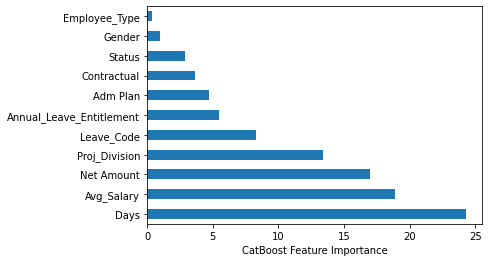

In [40]:
#Feature Importance for employees who use credit card fraudulently
feat_importances = pd.Series(cat.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.xlabel('CatBoost Feature Importance')

In [41]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")


Accuracy Score of Random Forest is : 0.908722688116835
Confusion Matrix : 
[[15608   614]
 [  986   321]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     16222
           1       0.34      0.25      0.29      1307

    accuracy                           0.91     17529
   macro avg       0.64      0.60      0.62     17529
weighted avg       0.90      0.91      0.90     17529



## Corporate Credit Card use outside of contract/Employment

In [42]:
# Truncate Transactions to pertinent columns
T_Transaction=CCD_TransactionData[['Employee Number',
 'Vendor Location',
 'Vendor Name',
 'Creditor Merchant Category',
 'Expense Date',
 'Status',
 'Expense Amount']].rename(columns={'Employee Number':'Employee_ID'})

# Truncate All Workers to pertinent columns
T_Workers=PD_EmployeeMaster[['Employee_Master',
 'Adm Plan',
 'BU Division',
 'Date Join',
 'Date Term',
 'Contractual',
 'Contract Start',
 'Contract End',
 'Country',
 'Employment Type']].rename(columns={'Employee_Master':'Employee_ID'})

In [43]:
# Merge Transactions and Workers
Tr_Workers=pd.merge(T_Workers,T_Transaction,how="inner",left_on="Employee_ID",right_on="Employee_ID")
# Contract Workers only
ContractWorkers=Tr_Workers[Tr_Workers['Contractual']=='Yes']
# Non-Contract Workers only
PermWorkers=Tr_Workers[Tr_Workers['Contractual']=='No']
# Retired PermWorkers
RetiredWorkers=PermWorkers[PermWorkers['Date Term'].notnull()]
# Employed PermWorkers
EmployedWorkers=PermWorkers[PermWorkers['Date Term'].isnull()]

In [44]:
# Retired workers with expenses past their termination date
RetiredSuspect=RetiredWorkers[RetiredWorkers['Expense Date']>RetiredWorkers['Date Term']]
RetiredSuspect['Days Past']=RetiredSuspect.apply(lambda x:x['Expense Date']-x['Date Term'],axis=1)
# Contracted workers with expenses past their contrct end date
ContractSuspect=ContractWorkers[ContractWorkers['Expense Date']>ContractWorkers['Contract End']]
ContractSuspect['Days Past']=ContractSuspect.apply(lambda x:x['Expense Date']-x['Contract End'],axis=1)

<ipython-input-44-9a41295fb32c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RetiredSuspect['Days Past']=RetiredSuspect.apply(lambda x:x['Expense Date']-x['Date Term'],axis=1)
<ipython-input-44-9a41295fb32c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ContractSuspect['Days Past']=ContractSuspect.apply(lambda x:x['Expense Date']-x['Contract End'],axis=1)


In [45]:
# Re-combine all workers
AllWorkersChecked=pd.concat([ContractSuspect, RetiredSuspect, EmployedWorkers], ignore_index=True)

In [46]:
# Total Epenses incurred outside of active date
AllWorkersChecked[AllWorkersChecked['Days Past'].notnull()].groupby('Employee_ID',as_index=False).sum()

,Employee_ID,Expense Amount
0,0020186,766.09
1,0020303,4354.90
2,0020305,1581.19
3,0020461,3684.59
4,0021418,11569.41
...,...,...
516,0240571,60.00
517,0240737,4218.82
518,0241089,437.42
519,0241685,406.65


In [47]:
# Export for TableAU
AllWorkersChecked['Fraud']=np.where(AllWorkersChecked['Days Past'].notnull(), True, False)
AllWorkersChecked.to_csv("TU_ExpenseOutsideActiveEmployment.csv")

# Quantile Regression

Observe pattern where fraudulent expense outside of active eployment is plotted against avg_Salary

                         QuantReg Regression Results                          
Dep. Variable:         Expense_Amount   Pseudo R-squared:            0.0001234
Model:                       QuantReg   Bandwidth:                       6924.
Method:                 Least Squares   Sparsity:                    1.741e+04
Date:                Sun, 20 Feb 2022   No. Observations:                  416
Time:                        22:43:26   Df Residuals:                      414
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4145.7200    722.510      5.738      0.000    2725.475    5565.965
Avg_Salary     0.0097      0.081      0.119      0.905      -0.150       0.170

The condition number is large, 1.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.


C:\Users\jieka\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\jieka\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


      q             a         b        lb        ub
0  0.05     43.931413  0.007678 -0.059864  0.075221
1  0.15    320.734098  0.005573 -0.087842  0.098987
2  0.25    666.428001  0.023178 -0.093442  0.139798
3  0.35    588.977367  0.074575 -0.055490  0.204640
4  0.45    437.645822  0.097233 -0.054868  0.249334
5  0.55   4649.176325  0.123854 -0.059211  0.306918
6  0.65   8978.563751  0.001670 -0.339514  0.342853
7  0.75   1909.451546  0.545334  0.386641  0.704027
8  0.85  22273.770848  0.763594 -0.060951  1.588139
{'a': 13206.513553161727, 'b': 0.16282738233528474, 'lb': -0.33271580576474935, 'ub': 0.6583705704353189}


C:\Users\jieka\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Text(0, 0.5, 'Expense_Amount')

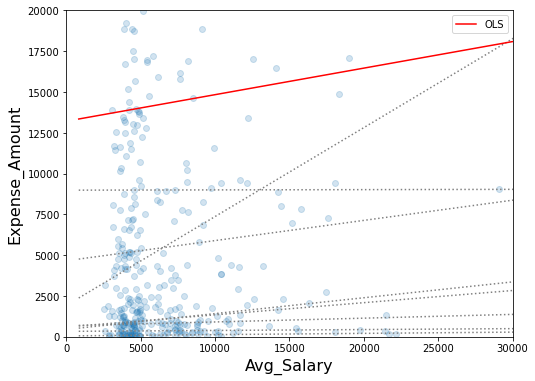

In [48]:
# Quantile regression
# Table with avg sal and expense spent
InactiveUse=AllWorkersChecked[AllWorkersChecked['Days Past'].notnull()].groupby('Employee_ID',as_index=False).sum()
InactiveUse=InactiveUse.merge(PD_Avg,how='inner',on='Employee_ID')
InactiveUse=InactiveUse.drop(['Fraud','Count','Amount'],axis=1)

#Model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Least Absolute Deviation
InactiveUse=InactiveUse.rename(columns={'Expense Amount':'Expense_Amount'})
mod = smf.quantreg("Expense_Amount ~ Avg_Salary",data=InactiveUse)
res = mod.fit(q=0.5)
print(res.summary())

# Prepare for plotting
quantiles = np.arange(0.05, 0.95, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Avg_Salary"]] + res.conf_int().loc[
        "Avg_Salary"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("Expense_Amount ~ Avg_Salary",data=InactiveUse).fit()
ols_ci = ols.conf_int().loc["Avg_Salary"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Avg_Salary"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

#Plot
x = np.arange(InactiveUse.Avg_Salary.min(), InactiveUse.Avg_Salary.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(InactiveUse.Avg_Salary, InactiveUse.Expense_Amount, alpha=0.2)
ax.set_xlim((0, 30000))
ax.set_ylim((0, 20000))
legend = ax.legend()
ax.set_xlabel("Avg_Salary", fontsize=16)
ax.set_ylabel("Expense_Amount", fontsize=16)

# Excess Annual Leave Taken over entitlement

In [49]:
leavedf=CCD_Leave
leavedf2 = CCD_Leave[CCD_Leave["Leave Type"]=="AL"]
leavedf["Annual Leave Entitlement"] = leavedf["Annual Leave Entitlement"].str[-2:]
leavedf["Annual Leave Entitlement"] = leavedf["Annual Leave Entitlement"].astype(str).astype(int)
leavedf = leavedf[["Employee Number","Annual Leave Entitlement"]].groupby(["Employee Number"], as_index=False).max()

In [50]:
df2  = leavedf2.groupby(["Employee Number"], as_index=False).sum()

In [51]:
# tempdf stores employees who took excess leave days
tempdf = pd.DataFrame(columns=["Employee Number", "entitlement", "days taken", "difference"])
for i,r in df2.iterrows():
    for j,k in leavedf.iterrows():
        if(k["Employee Number"] == r["Employee Number"]):
            if(r["Days"]>k["Annual Leave Entitlement"]):
                tempdf = tempdf.append({"Employee Number":k["Employee Number"] , "entitlement":k["Annual Leave Entitlement"],"days taken":r["Days"],"difference":r["Days"]-k["Annual Leave Entitlement"]}, ignore_index=True)

In [52]:
TU_ExcessLeave=leavedf.merge(tempdf,how='left',left_on='Employee Number',right_on='Employee Number')
TU_ExcessLeave['Excess']=TU_ExcessLeave['difference']
TU_ExcessLeave['Excess'].fillna("False",inplace=True)
TU_ExcessLeave.to_csv('TU_ExcessLeave.csv')